In [1]:
import numpy as np  # arrays and matrices
import pandas as pd  # data manipulation and analysis
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # matplotlib wrapper
from scipy import stats  # statistical tools
from sklearn.cluster import AgglomerativeClustering  # hierarchical clustering
from sklearn.neighbors import kneighbors_graph  # for the KNN sparse matrix
import missingno as msno  # missing data visualization

### **(1)** Enfoque desde el análisis estadístico: testeo de hipótesis y visualización.

In [2]:
# we load the data set
filename = '../data/worldcitiespop.csv'

In [3]:
# we read the CSV file into a dataframe object with just the columns we need
df = pd.read_csv(filename, sep=';', usecols=(0,1,5,6))

In [4]:
# check df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173647 entries, 0 to 3173646
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Country    object 
 1   City       object 
 2   Latitude   float64
 3   Longitude  float64
dtypes: float64(2), object(2)
memory usage: 96.9+ MB


In [5]:
# NaN distribution columnwise
df.isnull().sum(axis=0)

Country      0
City         6
Latitude     0
Longitude    0
dtype: int64

/home/gus/.local/share/virtualenvs/bci_desafio_data_analytics-4PuCjHLk/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until


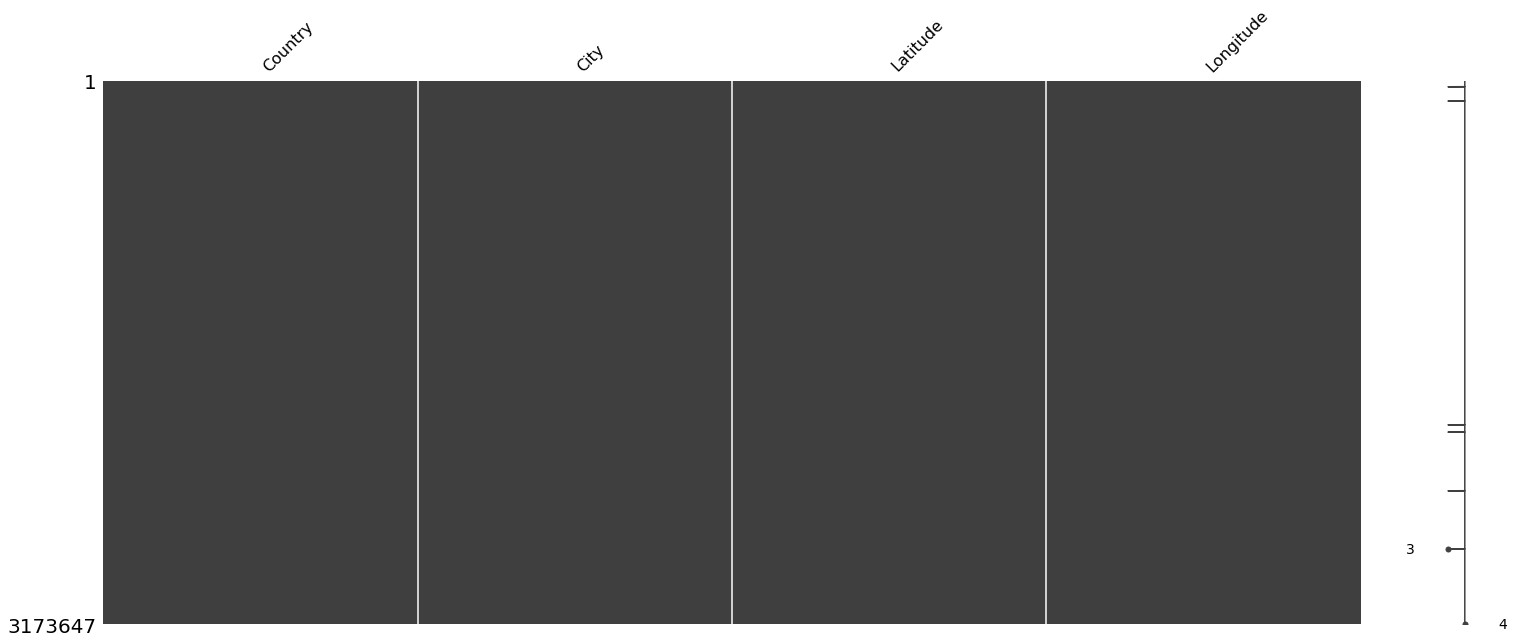

In [6]:
# NaN distribution as a whole
msno.matrix(df)
plt.tight_layout()

In [7]:
df_us = df[df['Country']=='us']  # US only locations
df_gb = df[df['Country']=='gb']  # UK only locations
del df  # for memory reasons

In [8]:
# Longitude restricted to a more sensible range
df_us_long = df_us[df_us['Longitude'].between(-130,-60)]

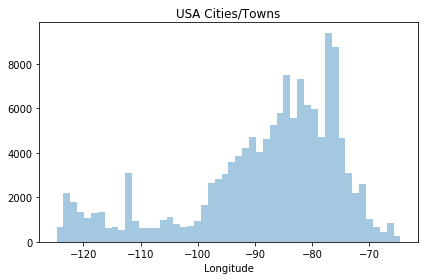

In [9]:
# plot histogram of US cities within the previous longitude range
sns.distplot(df_us_long['Longitude'], kde=False)  # not normed!
plt.title('USA Cities/Towns')
plt.tight_layout()

In [10]:
# now we define the matching city names
matches = list(set(df_gb['City']) & set(df_us['City']))  # highly optimized

In [11]:
df_us.reset_index(inplace=True)  # df cleaning

In [12]:
df_us.drop(columns=['index'])  # df cleaning

,Country,City,Latitude,Longitude
0,us,lost creek,37.481667,-83.325278
1,us,edgewood village,32.400556,-93.842500
2,us,trout dale,36.701944,-81.440556
3,us,trivoli,40.690556,-89.891944
4,us,barhamsville,37.454444,-76.840556
...,...,...,...,...
141977,us,woodman,37.521111,-82.044722
141978,us,fordoche,30.595833,-91.616389
141979,us,jerusalem mills,39.458333,-76.401944
141980,us,slemp,37.078611,-83.111667


In [13]:
# save the indices of the non matching locations to use them later
indices = []
for i,city in enumerate(df_us['City']):
    if city not in matches:
        indices.append(i)

In [14]:
# we clean the df, leaving only the city names present in both countries
df_us_gb = df_us.drop(index=indices).reset_index().drop(columns=['index', 'level_0', 'Country'])

In [15]:
df_us_gb

,City,Latitude,Longitude
0,avon,38.830278,-94.315556
1,perth,48.716389,-99.457500
2,linden,37.046389,-93.133889
3,pool,38.163611,-80.864444
4,hill,43.524167,-71.701389
...,...,...,...
9528,manchester,30.194167,-93.096944
9529,hampton,46.914444,-116.848333
9530,cobham,38.062778,-78.268333
9531,granville,41.261111,-89.227500


In [16]:
# Longitude restricted to a more sensible range
df_us_gb_long = df_us_gb[df_us_gb['Longitude'].between(-130,-60)]

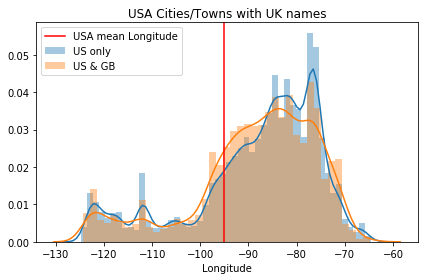

In [17]:
# now we add the US & GB histogram; but do note that BOTH are now normed!
sns.distplot(df_us_long['Longitude'], kde=True, label='US only')
sns.distplot(df_us_gb_long['Longitude'], kde=True, label='US & GB')
plt.axvline(-95, color='red', label='USA mean Longitude')
plt.legend()
plt.title('USA Cities/Towns with UK names')
plt.tight_layout()
plt.savefig('fig1.png', dpi=200)

In [18]:
# normality test 1
from scipy.stats import anderson
data = df_us_gb_long['Longitude']
result = anderson(data)
print('stat=%.3f' % (result.statistic))
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print('Probably Gaussian at the %.1f%% level' % (sl))
    else:
        print('Probably not Gaussian at the %.1f%% level' % (sl))

stat=203.455
Probably not Gaussian at the 15.0% level
Probably not Gaussian at the 10.0% level
Probably not Gaussian at the 5.0% level
Probably not Gaussian at the 2.5% level
Probably not Gaussian at the 1.0% level


In [19]:
# normality test 2
from scipy.stats import shapiro
stat, p = shapiro(data)
print('stat=%.3f, p=%f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.922, p=0.000000
Probably not Gaussian


/home/gus/.local/share/virtualenvs/bci_desafio_data_analytics-4PuCjHLk/lib/python3.6/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [20]:
# normality test 3
from scipy.stats import normaltest
data = df_us_long['Longitude']
stat, p = normaltest(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=18456.912, p=0.000
Probably not Gaussian


### **(2)** Enfoque desde el aprendizaje de máquina: _clustering_

In [21]:
df_us_gb

,City,Latitude,Longitude
0,avon,38.830278,-94.315556
1,perth,48.716389,-99.457500
2,linden,37.046389,-93.133889
3,pool,38.163611,-80.864444
4,hill,43.524167,-71.701389
...,...,...,...
9528,manchester,30.194167,-93.096944
9529,hampton,46.914444,-116.848333
9530,cobham,38.062778,-78.268333
9531,granville,41.261111,-89.227500


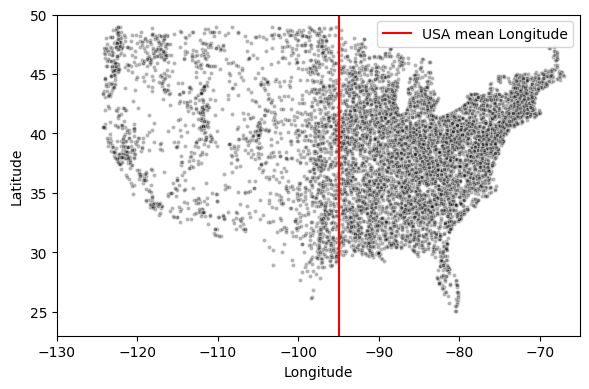

In [22]:
# plot of the US & GB cities, we can already infer asymmetry in terms of density
plt.figure(dpi=100)
X, Y ='Longitude', 'Latitude'
ALPHA = 0.3
MARKER = '.'
sns.scatterplot(x=X, y=Y, data=df_us_gb, color='black', alpha=ALPHA, marker=MARKER)
plt.axvline(-95, color='red', label='USA mean Longitude')
plt.xlim(-130,-65)
plt.ylim(23,50)
plt.legend()
plt.tight_layout()

In [23]:
# kmeans clustering estimation
from sklearn.cluster import KMeans

X = [list(a) for a in zip(df_us_gb['Longitude'].values,df_us_gb['Latitude'].values)]
X = np.array(X)

In [24]:
# here we force 2 clusters to appear
km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

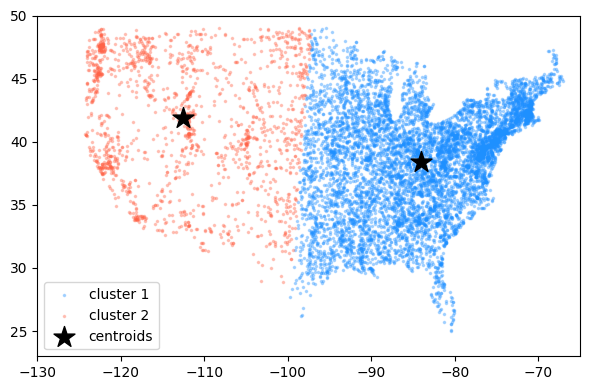

In [25]:
# plotting kmeans results with centroids
plt.figure(dpi=100)
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=10, c='dodgerblue', alpha=ALPHA,
    marker='.',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=10, c='tomato', alpha=ALPHA,
    marker='.',
    label='cluster 2'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='black', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.xlim(-130,-65)
plt.ylim(23,50)
#plt.axvline(-95, color='red')
plt.tight_layout()
plt.savefig('fig2.png', dpi=200)

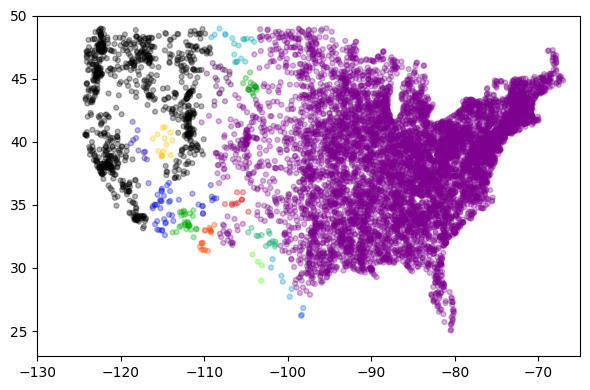

In [26]:
# hierarchical clustering with knn_graph connectivity matrix, and n_clusters=30
knn_graph = kneighbors_graph(X, 30, include_self=False)

plt.figure(dpi=100)
plt.subplot(1, 1, 1)
model = AgglomerativeClustering(linkage='average', connectivity=knn_graph, n_clusters=30)
model.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral,
            marker='.', s=50, alpha=0.3)
plt.xlim(-130,-65)
plt.ylim(23,50)
plt.tight_layout()
plt.savefig('fig3.png', dpi=200)

In [27]:
# how many locations are present in the purple cluster?
from collections import Counter, defaultdict
print(Counter(model.labels_)[2])

8429
